# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import nltk
# from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.simple import CharTokenizer
from tqdm import tqdm_notebook as tqdm
import pdb
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-Process Data
character tensors are set to take gradients

In [22]:
# create empty DataFrame to collect data
textDF = pd.DataFrame(columns=['text', 'target', 'prediction', 'length'])

# load each file as a DataFrame and append it to the main DataFrame
for f in ['amazon_cells_labelled', 'imdb_labelled', 'yelp_labelled']:
    file = f"../data/{f}.txt"
    df = pd.read_csv(file, names=['text', 'target'], sep='\t')
    textDF = textDF.append(df, ignore_index=True, sort=True)

# load stop words
# stop_words = set(stopwords.words('english'))

# instantiate WordNetLemmatizer class
lemmatizer = WordNetLemmatizer()

# instantiate CharTokenizer
char = CharTokenizer()

characters = [char for char in 'abcdefghijklmnopqrstuvwxyz 1234567890!@#$%/():"']

def PreProcess(sentence):
    
    # remove early stop words
    sentence = word_tokenize(sentence)
    # sentence = [ word for word in sentence if not word in stop_words ]
    
    # lemmatize all words in remaining sentence
    sentence = [ lemmatizer.lemmatize(word) for word in sentence ]
    
    # format all words to lower case
    sentence = [ word.lower() for word in sentence ]
    
    # convert the list of words back to a single string
    sentence = " ".join(str(x) for x in sentence)
    
    # tokenize the sentence by character
    sentence = char.tokenize(sentence)
    
    # remove unwanted characters
    sentence = [char for char in sentence if char in characters]
    
    # output pre-prossesed sentence
    return sentence

# apply PreProcess to textDF
textDF.text = textDF.text.apply(lambda x: PreProcess(x))

# add length of each review
textDF.length = textDF.text.apply(lambda x: len(x))

# filter out any obs w/ length == 0
textDF = textDF[textDF.length != 0]

# reset the index to make up for removing the 0 rows
textDF.reset_index(drop=True, inplace=True)

# preview textDF
textDF.head()

,length,prediction,target,text
0,82,NaN,0,"[s, o, , t, h, e, r, e, , i, s, , n, o, , ..."
1,27,NaN,1,"[g, o, o, d, , c, a, s, e, , , e, x, c, e, ..."
2,22,NaN,1,"[g, r, e, a, t, , f, o, r, , t, h, e, , j, ..."
3,79,NaN,0,"[t, i, e, d, , t, o, , c, h, a, r, g, e, r, ..."
4,17,NaN,1,"[t, h, e, , m, i, c, , i, s, , g, r, e, a, ..."


In [23]:
# get a list of the unique characters in textDF
# characters = list( set( [char for row in textDF.text for char in row] ) )

# get a dictionary with the tokens as keys and the one-hot value as the value
char_to_token = dict(zip(characters,[num for num in range(len(characters))]))

# get a dictionary with the one-hot value as the key and the token as the value
token_to_char = {value:key for key,value in char_to_token.items() }

# get the total length of features in character-space
D = len(char_to_token)

# dictionary for one-hot array for a character
token_to_encode = {}
for i in char_to_token.values():
    T = torch.zeros(1,D).type(torch.float32)
    T[:,i] = 1
    token_to_encode[i] = T
    
def token2Tensor(idx):
    characters = textDF.loc[idx, 'text']
    N = textDF.loc[idx,'length']
    T = torch.zeros(1,D,N).type(torch.float32)
    for i,char in enumerate(characters):
        T[0,:,i] = token_to_encode[ char_to_token[ char ] ]
    return T

def label2Tensor(idx):
    y = torch.zeros(1)
    y[0] = textDF.loc[idx,'target']
    return y.long()

def padding(K):
    P = (K-1)//2
    return P

def dialation(P,K):
    return (2*P) // (K-1)

def onehot(y):
    # N,K = y.shape[0], len(set(y))
    N,K = y.shape[0], 2
    Y = np.zeros((N,K))
    for i in range(N):
        Y[i,y[i]] = 1
    return Y

def accuracy(y,yhat):
    return np.mean(y == yhat)

def confusion_matrix(y,yhat):
    Y = onehot(y)
    Yhat = onehot(yhat)
    return Yhat.T @ Y

def load_model(savename='model.pkl'):
    return pickle.load( open( savename, "rb" ) )

# Construct Model

In [24]:
class Flatten(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        return x.view(x.size(0), -1)

class NLP_with_CNN(nn.Module):
    
    def __init__(self, DF, D, F=512, lambda2=0, lr=1e-4, pdrop=.55, momentum=.9, alpha=.99):
        super().__init__()
        
        self.model = nn.Sequential(
            
            # convolution 1
            nn.Conv1d(D, F, kernel_size=7, padding=3),
            nn.LeakyReLU(),
            
            # convolution 2
            nn.Conv1d(F, F, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            
            # convolution 3
            nn.Conv1d(F, F, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            
            # connector - flatten
            nn.AdaptiveAvgPool1d(F),
            Flatten(),
            
            # fully-connected 1
            nn.Linear(F**2, F),
            nn.LeakyReLU(),
            nn.Dropout(p=pdrop),
            
            # fully-connected 2
            nn.Linear(F, 100),
            nn.LeakyReLU(),
            nn.Dropout(p=pdrop),
            
            # output layer
            nn.Linear(100, 2),
        )
        
        # optimizer
        self.optimizer = optim.RMSprop(
            self.model.parameters(),
            lr = lr,
            alpha = alpha,
            eps = 1e-08,
            weight_decay = lambda2,
            momentum = momentum,
            centered = False)
        
        # loss function
        self.loss_function = nn.CrossEntropyLoss()
        
        # save DataFrame and dimentions
        self.DF = DF
        self.N = DF.shape[0]
        self.D = D
        
        # number of samples in each set
        N_train = int(self.N * .6)
        N_val = int(self.N * .2)
        N_test = self.N - N_train - N_val
        
        # indices for each set
        indices = np.random.RandomState(seed=0).permutation(self.N)
        self.indices = {
            'total'    : indices,
            'train'    : indices[ : N_train ],
            'validate' : indices[ N_train : N_train + N_val ],
            'test'     : indices[ N_train + N_val : ]
        }
        
    def forward(self,x):
        return self.model(x)
    
    def fit(self, epochs=1, batch_size=None, save=True):
        
        epochs = int(epochs)
        N = self.indices['train'].shape[0]
        if batch_size == None: batch_size = N
              
        for epoch in tqdm(range(epochs), leave=False):
        
            # choose index at from training set at random
            indices = self.indices['train'].copy()[:batch_size]
            np.random.shuffle(indices)
            
            # container to hold loss values
            LOSS = np.zeros(batch_size)
            
            for i,idx in enumerate(tqdm(indices, leave=False)):
                
                T = token2Tensor(idx)
                y = label2Tensor(idx)
                H = self.model(T)
                loss = self.loss_function(H,y)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                LOSS[i] = loss.item()

            # update LOSS
            if not hasattr(self, 'LOSS'):
                self.LOSS = LOSS.reshape([1,N])
            else:
                self.LOSS = np.vstack( (self.LOSS, LOSS) )
                
            # save model
            if save: self.save_model()
        
    def predict(self, key='total'):
        
        # go through each index in the desired dataset
        for idx in tqdm(self.indices[key]):
            
            T = token2Tensor(idx) # grab the tensor
            H = self.forward(T) # calc logits
            eH = torch.exp(H)
            phat = torch.log( eH / eH.sum() )
            yhat = phat.argmax().item() # find predictions
            self.DF.loc[idx,'prediction'] = yhat # update review prediction in DF
            
    def evaluate_performance(self, keys=['train', 'validate', 'test']):
        
        # empty container to hold accuracies
        self.accuracy = {}
        
        # go through each dataset
        for key in keys:
            
            # get the filtered dataset
            df = self.select_dataset(key)
            
            # grab the targets and predictions
            y = df.target.to_numpy(dtype=np.int32)
            yhat = df.prediction.to_numpy(dtype=np.int32)
            
            # add to accuracy
            self.accuracy[key] = accuracy(y,yhat)
            
            # calculate Confusion Matrix for the test set
            if key == 'test':
                self.confusion_matrix = confusion_matrix(y,yhat) 
    
    def plot_loss(self):
        
        fig,ax = plt.subplots(nrows=2, figsize=(10,10))
        
        ax[0].set_title("Loss for All Training Sessions")
        ax[0].plot( self.LOSS.flatten() )
        ax[0].set_ylabel("Loss")
        N1,N2 = self.LOSS.shape
        for i in range(N1+1):
            ax[0].vlines(i*N2,self.LOSS.min(),self.LOSS.max(), color='r', linewidth=1, linestyles='dashed')
        
        ax[1].set_title("Loss for Latest Training Session")
        ax[1].plot( self.LOSS[-1, :] )
        ax[1].set_ylabel("Loss")
        
        fig.text(0.5, 0.04, 'Iterations', ha='center')
                
    def save_model(self, savename='model.pkl'):
        pickle.dump(self, open(savename, "wb"))
        
    def select_dataset(self, key):
        return self.DF[self.DF.index.isin(self.indices[key])]

In [32]:
# instantiate model
model = NLP_with_CNN(textDF.copy(), D, F=256, lambda2=0, pdrop=.6, momentum=.9, alpha=.99, lr=1e-4)

# Train Model

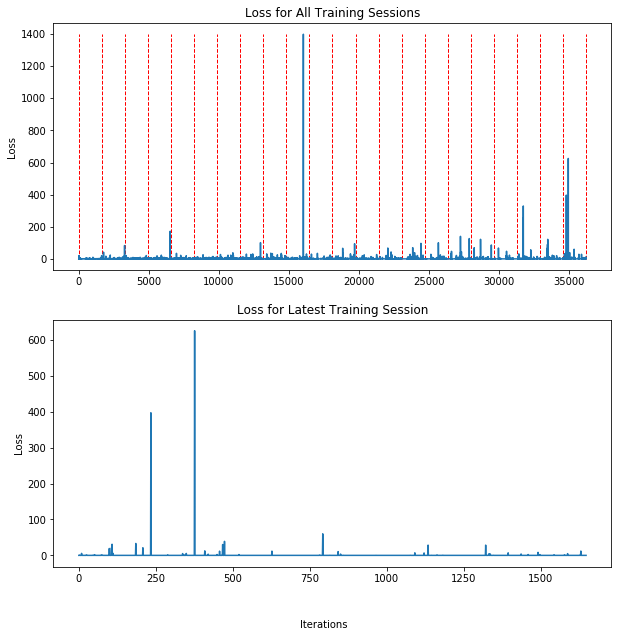

In [49]:
model.fit(epochs=5)
model.plot_loss()

In [50]:
model.predict()
model.evaluate_performance()

In [47]:
model.accuracy

{'train': 0.9678398058252428,
 'validate': 0.7449908925318761,
 'test': 0.7531760435571688}

In [48]:
model.confusion_matrix

array([[224., 108.],
       [ 28., 191.]])

In [ ]:
df = model.select_dataset('train');df.head()

In [ ]:
df[df.prediction==0].shape[0]

In [ ]:
df[df.prediction==1].shape[0]